In [1]:
# FLATMAP view

In [1]:
'''
Script for generating the GIF in the README
See the documentation for more examples and API descriptions:
http://mouse-connectivity-models.readthedocs.io/en/latest/
'''

import os
import logging

import subprocess

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm

from mcmodels.core import Mask, VoxelModelCache
from mcmodels.core.cortical_map import CorticalMap

In [2]:
logger = logging.getLogger(name=__name__)


In [3]:
# file path where the data files will be downloaded
MANIFEST_FILE = os.path.join(os.path.dirname(os.path.abspath('')),
                             '../connectivity', 'mcmodels_manifest.json')

OUTPUT_DIR = 'tv_imgs'
GIF_CONVERT_COMMAND = 'convert -delay 3x100 -size 50x50 *.png output.gif'

# Image overlay (showing regions of the brain)
flat_map_overlay = plt.imread("cortical_map_top_down.png")
# image.size to get the size of the image

In [4]:
# caching object for retrieving the connectivity model data
# can find file in mcmodels folder
cache = VoxelModelCache(manifest_file=MANIFEST_FILE)


In [5]:
# load voxel model
logging.info('loading voxel array')

# Get voxel connectictivity array from cache
voxel_array, source_mask, target_mask = cache.get_voxel_connectivity_array()
reference_shape = source_mask.reference_space.annotation.shape
vmax = 1.2 * np.percentile(voxel_array.nodes, 99)

In [6]:
print(voxel_array)
print(source_mask)
print(target_mask)
print(reference_shape)
print(vmax)

VoxelConnectivityArray(dtype=float64, shape=(226346, 448962))
Mask(hemisphere_id=2, structure_ids=[315, ..., 512])
Mask(hemisphere_id=3, structure_ids=[315, ..., 512])
(132, 80, 114)
0.0013824748294428008


In [7]:
# 2D Cortical Surface Mapper
# projection: can change to "flatmap" if desired
mapper = CorticalMap(projection='top_view')
# quick hack to fix bug (out of bounds thing)
mapper.view_lookup[51, 69] = mapper.view_lookup[51, 68]
mapper.view_lookup[51, 44] = mapper.view_lookup[51, 43]

In [8]:
# colormaps
cmap_view = matplotlib.cm.inferno
cmap_pixel = matplotlib.cm.cool
cmap_view.set_bad(alpha=0)
cmap_pixel.set_bad(alpha=0)

<ipython-input-8-a269882e0081>:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("inferno"))
  cmap_view.set_bad(alpha=0)
<ipython-input-8-a269882e0081>:5: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("cool"))
  cmap_pixel.set_bad(alpha=0)


(114, 132)


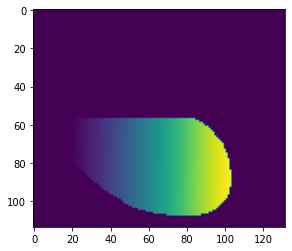

In [9]:
# only want R hemisphere
lookup = mapper.view_lookup.copy().T # transpose for vertical pixel query

#set the left hemisphere values to -1
lookup[:lookup.shape[0]//2, :] = -1

# Prints the dimensions of lookup
print(lookup.shape)
#print(lookup[x][y])

# Prints the dimensions of the overlay
# print(flat_map_overlay.shape)
# print(flat_map_overlay[100][250])

# Displays the mapping of the flatmap
plt.imshow(lookup)


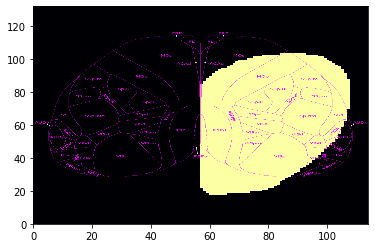

In [10]:
# Space for testing overlay
im = plt.pcolormesh(lookup.T, zorder=1, cmap=cmap_view, vmin=0, vmax=vmax)

# plot source voxel
#adds the blue pixel representing the injection site
#plt.pcolormesh(pixel, zorder=2, cmap=cmap_pixel, vmin=0, vmax=1)

# plot overlay
extent = plt.gca().get_xlim() + plt.gca().get_ylim()
plt.imshow(flat_map_overlay, interpolation="nearest", extent=extent, zorder=3, aspect = "auto")





path shape:  (18, 3)
row_idx shape:  ()
flat_view shape:  (132, 114)
pixel:  [[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


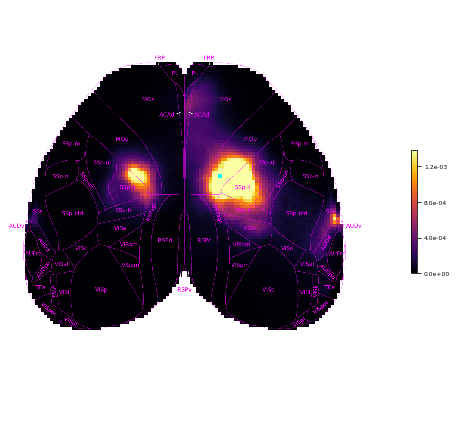

In [13]:
# dict(2D lookup_value -> avg(path))
logging.info('beginning image creation')
x = 68
y = 54
#i is the pixel
#val is the index of the path  
i, val = 0, lookup[x][y]
# get the mean path voxel
# mapper paths: array of values representing different paths (voxel points)
path = mapper.paths[val][mapper.paths[val].nonzero()]

# path: a path through the brain (path represented by 3D coordinates)
# reference shape: represents how big mouse brain is
path = np.vstack([np.unravel_index(x, reference_shape) for x in path])
print("path shape: ", path.shape)

# voxel: a coordinate
# top voxel along path
# voxel = tuple(map(int, path[0]))
# average voxel along path (about 1/2 the way down, returns a tuple coordinate)
voxel = tuple(map(int, path.mean(axis=0)))
#print("voxel: ", voxel.shape)

try:
    # get row_index
    row_idx = source_mask.get_flattened_voxel_index(voxel)
    print("row_idx shape: ", row_idx.shape)

except ValueError:
    logging.warning('voxel %s not in mask', voxel)
else:
    # get voxel expression

    # voxel array: a matrix 
    # matrix[row_index]: returns a vector of connectivity strengths
    # converts the target mask/or voxel_array to a 3D array to be plotted on top of
    # since matrix[] returns a vector
    volume = target_mask.fill_volume_where_masked(np.zeros(reference_shape),voxel_array[row_idx])
    #print("volume shape: ", volume.shape)
    # look at maximum value in 3D array (volume)

    # map to cortical surface:

    # fill non-brain parts with NaN, so it looks transparent 
    flat_view = mapper.transform(volume, fill_value=np.nan)
    print("flat_view shape: ", flat_view.shape)

    # injection location   
    # masks out everything that is not the injection site, so you can plot the blue pixel
    pixel = np.ma.masked_where(mapper.view_lookup != val, flat_view, copy=False)
    print("pixel: ", mapper.view_lookup)

    # plot & params (fig is 8 by 4 inches)
    fig, ax = plt.subplots(figsize=(14, 6))

    # plot connectivity: 
    # color map with connectivity within bounds of brain on flat_view
    im = plt.pcolormesh(flat_view, zorder=1, cmap=cmap_view, vmin=0, vmax=vmax)  # zorder --> blue (injection) pixel on top of image 

    # plot source voxel (a blue pixel representing the injection site):
    plt.pcolormesh(pixel, zorder=2, cmap=cmap_pixel, vmin=0, vmax=1)

    plt.gca().invert_yaxis() # flips yaxis

    # removes the axis
    plt.axis('off')

    # plot overlay
    extent = plt.gca().get_xlim() + plt.gca().get_ylim()

    plt.imshow(flat_map_overlay, interpolation="nearest", extent=extent, zorder=3)

    # add colorbar (bar on side showing connection strength)
    cbar = plt.colorbar(im, shrink=0.3, use_gridspec=True, format="%1.1e")
    #change marks on bar to be at these values
    cbar.set_ticks([0, 0.0004, 0.0008, 0.0012])
    #make label smaller
    cbar.ax.tick_params(labelsize=6) 
    plt.tight_layout()
    filename="topview_" + str(x) +", "+str(y)
    plt.savefig(filename.replace(".","_")+".png", dpi=600, bbox_inches='tight')
